##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import string

####  <font color=SlateBlue>Google Colab</font>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

####  <font color=SlateBlue>Reading Images</font>

In [ ]:
import os
from PIL import Image

####  <font color=SlateBlue>Preprocessing</font>

In [ ]:
#Tokenizing 
import nltk
nltk.download('punkt')

import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchtext.data import Field, TabularDataset

####  <font color=SlateBlue>CNN</font> ####

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

##  <font color=MediumSlateBlue>Reading Captions and Creating Training and Test Datasets</font> ##

####  <font color=SlateBlue>Captions file is read and turned into a .csv file </font> ####

In [ ]:
#Set the location of your .txt file in as the input
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Deep Learning/HW/3/Captions.txt") 

####  <font color=SlateBlue>Removing punctuations from captions and lower case all words</font> ####

In [ ]:
for punc in string.punctuation+'\n':
  df["caption"] = df.caption.str.replace(punc, " ")
  
df["caption"] = df.caption.str.lower()

####  <font color=SlateBlue>Selecting 90% of data for training dataset and the rest for test dataset</font> ####

In [ ]:
numImg = int(len(df)/5)

trainIndx = random.sample(range(0, numImg), int(0.9*numImg))
trainIndx = [5*i+j for i in trainIndx for j in range(0,5)]

testIndx = [i for i in range(0,numImg) if not i in trainIndx]
testIndx = [5*i+j for i in testIndx for j in range(0,5)]

In [ ]:
trainDF = df.loc[trainIndx, :]
testDF = df.loc[testIndx, :]

####  <font color=SlateBlue>Saving training and test datasets in .csv format for ferthur usage.</font> ####

In [ ]:
trainDF.to_csv(r'Train_Captions.csv', index=False)
testDF.to_csv(r'Test_Captions.csv', index=False)

##  <font color=MediumSlateBlue>Building Vocabulary and Creating Train and Test Datasets and Dataloader</font> ##

####  <font color=SlateBlue>Vocabulary class that can calculate the tokenized represetation of sentences</font> ####

In [ ]:
class Vocabulary():
  def __init__(self, minFreq):
    self.minFreq = minFreq

    self.vocabs = Field(sequential=True, 
                        use_vocab=True, 
                        init_token = '<sos>', 
                        eos_token = '<eos>',
                        tokenize=self.tokenizer, 
                        lower=True)

  def __len__(self): return len(self.vocabs.vocab.stoi)

  def tokenizer(self, text): return nltk.word_tokenize(text)

  def buildVocabulary(self, dataPath, format):
    fields = {'caption': ('c', self.vocabs)}
    dataset = TabularDataset(path=dataPath, format=format, 
                             fields=fields)
    
    self.vocabs.build_vocab(dataset, max_size=10000, min_freq=self.minFreq)

  def numericalize(self, text):
    tokenizedText = self.tokenizer(text)

    return [
        self.vocabs.vocab.stoi[token] 
        if token in self.vocabs.vocab.stoi 
        else self.vocabs.vocab.stoi['<unk>']
        for token in tokenizedText
        ]

####  <font color=SlateBlue>FlickerDataset is a class which reads all images and their captions.</font> ####

In [ ]:
class FlickrDataset(Dataset):
  def __init__(self, imgLoc, captionsLoc, vocabCaption, transform=None, mode='Train'):
    self.imgLoc = imgLoc
    self.transform = transform

    self.df = pd.read_csv(captionsLoc)

    self.imgs = self.df['image']
    self.captions = self.df['caption']

    self.vocabCaption = vocabCaption

    if mode == 'Train':
      self.vocabCaption.buildVocabulary(
          dataPath=captionsLoc, 
          format='csv'
          )

  def __len__(self): return len(self.df)

  def getBuiltVocab(self): return self.vocabCaption

  def __getitem__(self, indx):
    caption = self.captions[indx]

    imgIndx = self.imgs[indx]
    img = Image.open(os.path.join(self.imgLoc, imgIndx)).convert('RGB')

    if self.transform is not None:
      img = self.transform(img)

    numericalizedCaption = [self.vocabCaption.vocabs.vocab.stoi['<sos>']]
    numericalizedCaption.extend(self.vocabCaption.numericalize(caption))
    numericalizedCaption.append(self.vocabCaption.vocabs.vocab.stoi['<eos>'])

    return img, torch.tensor(numericalizedCaption)

####  <font color=SlateBlue>MyCollate is a class which is responsible for padding. </font> ####

In [ ]:
class MyCollate():
  def __init__(self, padIndx):
    self.padIndx = padIndx

  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs, dim=0)

    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, 
                           batch_first=False, 
                           padding_value=self.padIndx)

    return imgs, targets

####  <font color=SlateBlue>Getloader is a function returning a dataloader as well as the created dataset based on the given data</font> ####

In [ ]:
def getLoader(imgLoc, 
              captionsLoc,  
              vocabCaption, 
              transform, 
              mode, 
              batchSize=256, 
              numWorkers=0, 
              shuffle=True, 
              pinMemory=True):
  
  dataset = FlickrDataset(imgLoc, 
                          captionsLoc, 
                          vocabCaption, 
                          transform, 
                          mode)

  padIndx = (dataset.getBuiltVocab()).vocabs.vocab.stoi['<pad>']

  loader = DataLoader(
      dataset=dataset,
      batch_size=batchSize,
      num_workers=numWorkers,
      shuffle=shuffle,
      pin_memory=pinMemory,
      collate_fn=MyCollate(padIndx=padIndx),
  )

  return loader, dataset

####  <font color=SlateBlue>Creating train dataloader and dataset.</font> ####

In [ ]:
transform = T.Compose([T.Resize(300),
                      T.RandomCrop(256),
                      T.ToTensor(),
                      T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainDataLoader, trainDataset = getLoader(
    imgLoc='/content/gdrive/My Drive/Colab Notebooks/Deep Learning/HW/3/Dataset',
    captionsLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Captions/Train_Captions.csv',
    vocabCaption=Vocabulary(5),
    transform=transform,
    mode='Train',
    batchSize=256,
    numWorkers=2
)


####  <font color=SlateBlue>Creating test dataloader and dataset.</font> ####

In [ ]:
testDataLoader, testDataset = getLoader(
    imgLoc='/content/gdrive/My Drive/Colab Notebooks/Deep Learning/HW/3/Dataset',
    captionsLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Captions/Test_Captions.csv',
    vocabCaption=trainDataset.getBuiltVocab(),
    transform=transform,
    mode='Test',
    batchSize=3,
    numWorkers=2
)

##  <font color=MediumSlateBlue>Creating the Neural Network.</font> ##

####  <font color=SlateBlue>Creating the Encoder Module.</font> ####

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embedSize, freezeState):
      super(EncoderCNN, self).__init__()

      resnet = models.resnet18(pretrained=True)

      if not freezeState: 
        for param in resnet.parameters(): param.requires_grad = False

      resnet.fc = nn.Linear(resnet.fc.in_features, embedSize)

      self.encoder = nn.Sequential(
          resnet,
          nn.ReLU(),                                    #ReLU as activation function.
          nn.Dropout(0.5)                              #Dropout for regularization.
      )
          
    def forward(self, imgs):
      return (self.encoder(imgs))

####  <font color=SlateBlue>Creating the Dencoder Module.</font> ####

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self, embedSize, hiddenSize, vocabSize, numLayers):
    super(DecoderRNN, self).__init__()

    self.embed = nn.Embedding(vocabSize, embedSize)
    self.lstm = nn.LSTM(embedSize, hiddenSize, numLayers)
    self.linear = nn.Linear(hiddenSize, vocabSize)
    self.dropout = nn.Dropout(0.5)

  def forward(self, features, captions):
    embeddings = torch.cat((features.unsqueeze(0), self.dropout(self.embed(captions))), dim=0) #Adding a dimension to feature so that it is a sequential figure as well as the embeddings. Than concat them so that the first element is the feature
    hiddens, _ = self.lstm(embeddings)
    return self.linear(hiddens)

####  <font color=SlateBlue>Creating the Connector Module.</font> ####

In [ ]:
class CNNtoRNN(nn.Module):
  def __init__(self, embedSize, hiddenSize, vocabSize, numLayers, freezeState):
    super(CNNtoRNN, self).__init__()

    self.encoder = EncoderCNN(embedSize, freezeState)
    self.decoder = DecoderRNN(embedSize, hiddenSize, vocabSize, numLayers)

  def forward(self, images, captions):
    return self.decoder(self.encoder(images), captions) #Giving the output of encoder which is the features as well as the captions to the decoder

  def captionImage(self, image, vocab, maxLength=50):
    resultCaption = []

    with torch.no_grad():
      x = self.encoder(image).unsqueeze(0) #So that the dimension of the extracted features is as the same as the eements in the batch
      states = None

      for _ in range(maxLength):
        hiddens, states = self.decoder.lstm(x, states)
        output = self.decoder.linear(hiddens.squeeze(0))
        predicted = output.argmax(1)
        resultCaption.append(predicted.item())
        x = self.decoder.embed(predicted).unsqueeze(0)

        if vocab.itos[predicted.item()] == '<eos>':
          break

    caption = [vocab.itos[idx] for idx in resultCaption]
    return ' '.join(caption)

##  <font color=MediumSlateBlue>Training the Neural Network.</font> ##

In [ ]:
def train(trainDataLoader, trainDataset,
          testDataLoader, testDataset,
          embedSize=300, hiddenSize=256, 
          freezeState=True
          ):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  datasetVocab = (trainDataset.getBuiltVocab()).vocabs.vocab

  #Hyperparameters
  vocabSize = len(datasetVocab)
  numLayers = 1
  learningRate = 3e-4
  numEpochs = 30


  #Model creation
  model = CNNtoRNN(embedSize, hiddenSize, vocabSize, numLayers, freezeState).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=datasetVocab.stoi['<pad>'])
  optimizer = optim.Adam(model.parameters(), lr=learningRate)

  allEpochTrainLoss = []

  for numEpoch in range(numEpochs):
    print('Epoch %d has started......' %(numEpoch+1))
    oneEpochTrainLoss = 0

    print('Training the network......')
    model.train()

    for iteration, (imgs, captions) in enumerate(trainDataLoader):
      imgs = imgs.to(device)
      captions = captions.to(device)

      outputs = model(imgs, captions[:-1])
      loss = criterion(outputs.reshape(-1, outputs.shape[2]), 
                        captions.reshape(-1))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      oneEpochTrainLoss += loss.item()

      #Printing training loss every 20 iterations
      if (iteration+1)%20==0:
        print('Iteration:%d \t Loss:%1.5f' %(iteration+1, oneEpochTrainLoss/(iteration+1)))

    #Printing training loss at the end of each epoch
    print('At the end of epoch %d the average train loss is: %1.5f' %(numEpoch+1, oneEpochTrainLoss/len(trainDataLoader)))
    allEpochTrainLoss.append(oneEpochTrainLoss/len(trainDataLoader))

    #Plotting train loss in every 10 epochs
    if (numEpoch+1)%10==0:
      plt.plot(allEpochTrainLoss, label='Train Loss', color='slateblue')
      plt.title('Loss vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

    print('Testing the network......')
    model.eval()

    with torch.no_grad():
      for imgs, _ in testDataLoader:
        imgs = imgs.to(device)
        for batchIndx in range(imgs.shape[0]):
          output = model.captionImage(imgs[batchIndx,:,:,:].unsqueeze(0), datasetVocab)
          print(output)
          plt.xticks(())
          plt.yticks(())
          plt.imshow(imgs[batchIndx,:,:,:].data.cpu().permute(1, 2, 0))
          plt.show()
          print('...............................................')
        break


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1 has started......
Training the network......
Iteration:20 	 Loss:7.71136
Iteration:40 	 Loss:6.99670
Iteration:60 	 Loss:6.27812
Iteration:80 	 Loss:5.85986
Iteration:100 	 Loss:5.58909
Iteration:120 	 Loss:5.38603
Iteration:140 	 Loss:5.22915
At the end of epoch 1 the average train loss is: 5.20803
Testing the network......
<sos> a man in a man in a man in a <eos>


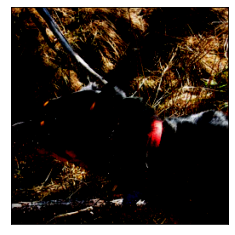

...............................................
<sos> a man in a man in a man in a <eos>


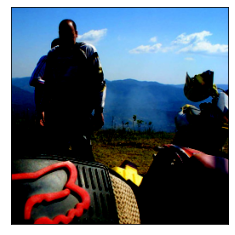

...............................................
<sos> a man in a man in a man in a <eos>


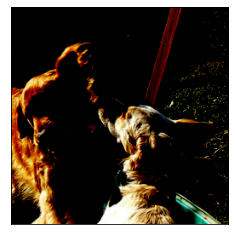

...............................................
Epoch 2 has started......
Training the network......
Iteration:20 	 Loss:4.18940
Iteration:40 	 Loss:4.13698
Iteration:60 	 Loss:4.09927
Iteration:80 	 Loss:4.07060
Iteration:100 	 Loss:4.04324
Iteration:120 	 Loss:4.01689
Iteration:140 	 Loss:3.99096
At the end of epoch 2 the average train loss is: 3.98609
Testing the network......
<sos> a man in a red shirt and a white dog is running on a <unk> <eos>


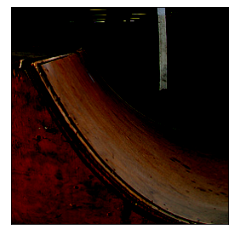

...............................................
<sos> a man in a red shirt and a white dog is running on a <unk> <eos>


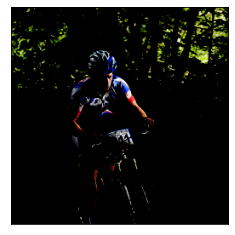

...............................................
<sos> a man in a red shirt and a white dog is running on a <unk> <eos>


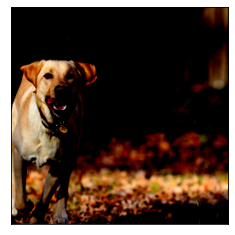

...............................................
Epoch 3 has started......
Training the network......
Iteration:20 	 Loss:3.78363
Iteration:40 	 Loss:3.76397
Iteration:60 	 Loss:3.75105
Iteration:80 	 Loss:3.73309
Iteration:100 	 Loss:3.72006
Iteration:120 	 Loss:3.70584
Iteration:140 	 Loss:3.69461
At the end of epoch 3 the average train loss is: 3.69144
Testing the network......
<sos> a man in a red shirt is jumping a <unk> <eos>


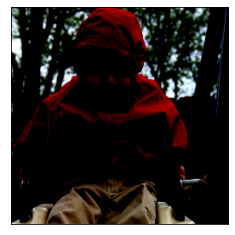

...............................................
<sos> a man in a red shirt is jumping a <unk> <eos>


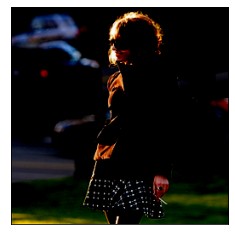

...............................................
<sos> a man in a red shirt is jumping a <unk> <eos>


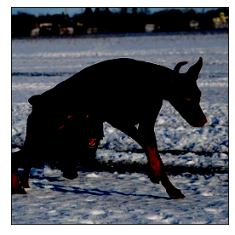

...............................................
Epoch 4 has started......
Training the network......
Iteration:20 	 Loss:3.58057
Iteration:40 	 Loss:3.57918
Iteration:60 	 Loss:3.56458
Iteration:80 	 Loss:3.55913
Iteration:100 	 Loss:3.54808
Iteration:120 	 Loss:3.53625
Iteration:140 	 Loss:3.52883
At the end of epoch 4 the average train loss is: 3.52851
Testing the network......
<sos> a man in a red shirt is standing on a <unk> <eos>


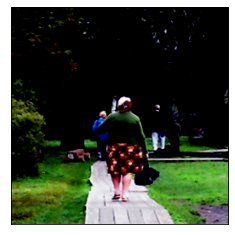

...............................................
<sos> a man in a red shirt is standing on a <unk> <eos>


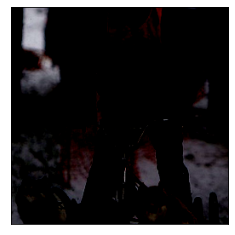

...............................................
<sos> a man in a red shirt is standing on a <unk> <eos>


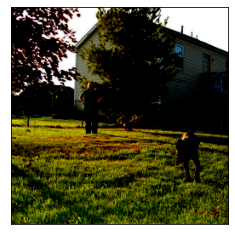

...............................................
Epoch 5 has started......
Training the network......
Iteration:20 	 Loss:3.43386
Iteration:40 	 Loss:3.44884
Iteration:60 	 Loss:3.44433
Iteration:80 	 Loss:3.43960
Iteration:100 	 Loss:3.42884
Iteration:120 	 Loss:3.42174
Iteration:140 	 Loss:3.41601
At the end of epoch 5 the average train loss is: 3.41412
Testing the network......
<sos> a man in a red shirt is standing on a <unk> <eos>


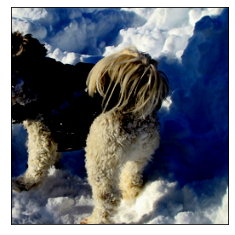

...............................................
<sos> a man in a red shirt is standing on a <unk> <eos>


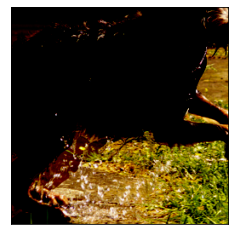

...............................................
<sos> a man in a red shirt is standing on a <unk> <eos>


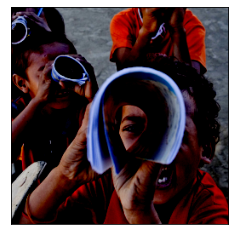

...............................................
Epoch 6 has started......
Training the network......
Iteration:20 	 Loss:3.32104
Iteration:40 	 Loss:3.33797
Iteration:60 	 Loss:3.33316
Iteration:80 	 Loss:3.33127
Iteration:100 	 Loss:3.33181
Iteration:120 	 Loss:3.32916
Iteration:140 	 Loss:3.32604
At the end of epoch 6 the average train loss is: 3.32556
Testing the network......
<sos> a man in a red shirt is standing on a beach <eos>


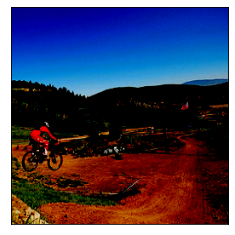

...............................................
<sos> a man in a red shirt is standing on a beach <eos>


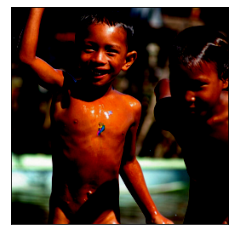

...............................................
<sos> a man in a red shirt is standing on a beach <eos>


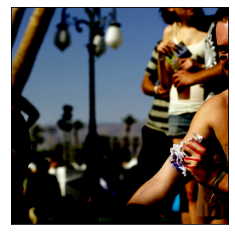

...............................................
Epoch 7 has started......
Training the network......
Iteration:20 	 Loss:3.26655
Iteration:40 	 Loss:3.26841
Iteration:60 	 Loss:3.26690
Iteration:80 	 Loss:3.26753
Iteration:100 	 Loss:3.25971
Iteration:120 	 Loss:3.25856
Iteration:140 	 Loss:3.25349
At the end of epoch 7 the average train loss is: 3.25372
Testing the network......
<sos> a man in a red shirt is standing on a beach <eos>


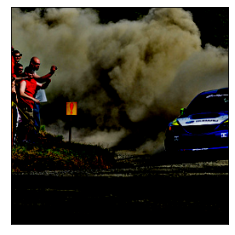

...............................................
<sos> a man in a red shirt is standing on a beach <eos>


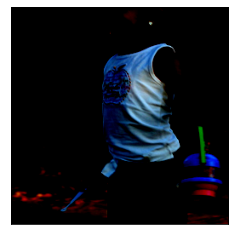

...............................................
<sos> a man in a red shirt is standing on a beach <eos>


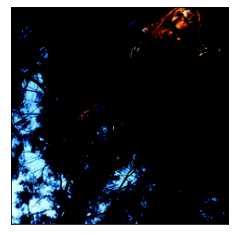

...............................................
Epoch 8 has started......
Training the network......
Iteration:20 	 Loss:3.19756
Iteration:40 	 Loss:3.18923
Iteration:60 	 Loss:3.19755
Iteration:80 	 Loss:3.19916
Iteration:100 	 Loss:3.19810
Iteration:120 	 Loss:3.19371
Iteration:140 	 Loss:3.19265
At the end of epoch 8 the average train loss is: 3.19197
Testing the network......
<sos> a man in a red shirt is standing on a bench <eos>


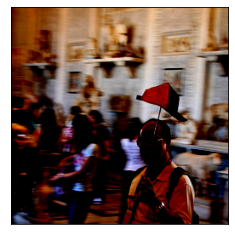

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


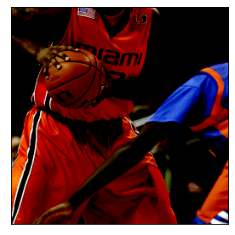

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


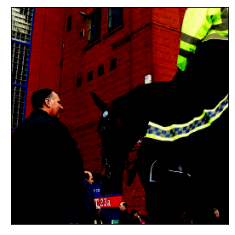

...............................................
Epoch 9 has started......
Training the network......
Iteration:20 	 Loss:3.15673
Iteration:40 	 Loss:3.15456
Iteration:60 	 Loss:3.15314
Iteration:80 	 Loss:3.15349
Iteration:100 	 Loss:3.14687
Iteration:120 	 Loss:3.14144
Iteration:140 	 Loss:3.13662
At the end of epoch 9 the average train loss is: 3.13520
Testing the network......
<sos> a man in a red shirt is standing on a bench <eos>


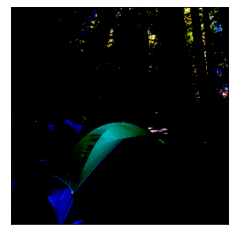

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


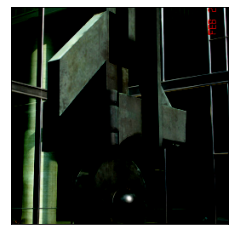

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


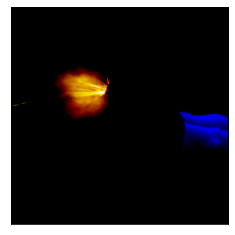

...............................................
Epoch 10 has started......
Training the network......
Iteration:20 	 Loss:3.09548
Iteration:40 	 Loss:3.09908
Iteration:60 	 Loss:3.09474
Iteration:80 	 Loss:3.08842
Iteration:100 	 Loss:3.08621
Iteration:120 	 Loss:3.07958
Iteration:140 	 Loss:3.07675
At the end of epoch 10 the average train loss is: 3.07710


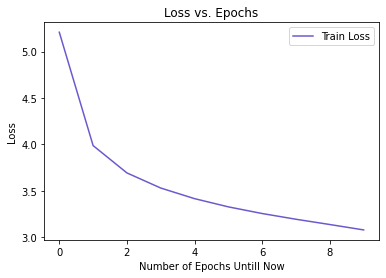

Testing the network......
<sos> a dog is running through the grass <eos>


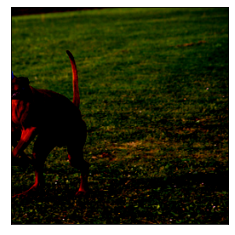

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


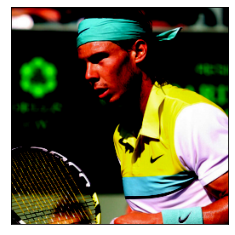

...............................................
<sos> a dog is running through the grass <eos>


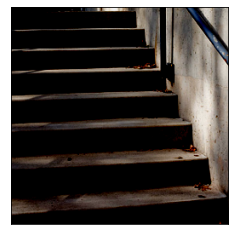

...............................................
Epoch 11 has started......
Training the network......
Iteration:20 	 Loss:3.03574
Iteration:40 	 Loss:3.03492
Iteration:60 	 Loss:3.03655
Iteration:80 	 Loss:3.03660
Iteration:100 	 Loss:3.03458
Iteration:120 	 Loss:3.03186
Iteration:140 	 Loss:3.03174
At the end of epoch 11 the average train loss is: 3.03141
Testing the network......
<sos> a man in a red shirt is standing on a bench <eos>


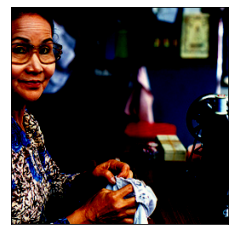

...............................................
<sos> a dog is running through the grass <eos>


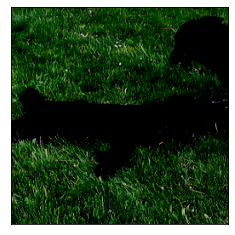

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


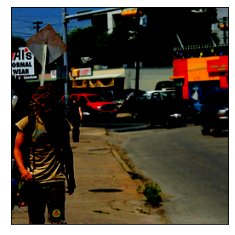

...............................................
Epoch 12 has started......
Training the network......
Iteration:20 	 Loss:2.99416
Iteration:40 	 Loss:2.99189
Iteration:60 	 Loss:2.99071
Iteration:80 	 Loss:2.99331
Iteration:100 	 Loss:2.99323
Iteration:120 	 Loss:2.99020
Iteration:140 	 Loss:2.99221
At the end of epoch 12 the average train loss is: 2.99167
Testing the network......
<sos> a man in a red shirt and a black shirt and a black hat and a red shirt and a black hat <eos>


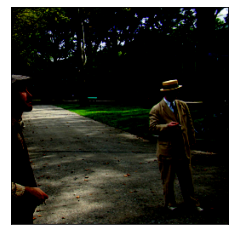

...............................................
<sos> a man in a red shirt is standing on a bench with a <unk> in the background <eos>


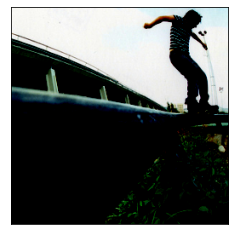

...............................................
<sos> a man in a red shirt and a black hat and a red shirt and a black hat and a blue shirt and a black hat <eos>


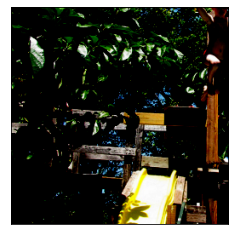

...............................................
Epoch 13 has started......
Training the network......
Iteration:20 	 Loss:2.97033
Iteration:40 	 Loss:2.96582
Iteration:60 	 Loss:2.96014
Iteration:80 	 Loss:2.96055
Iteration:100 	 Loss:2.96124
Iteration:120 	 Loss:2.95928
Iteration:140 	 Loss:2.95490
At the end of epoch 13 the average train loss is: 2.95407
Testing the network......
<sos> a dog is running through the grass <eos>


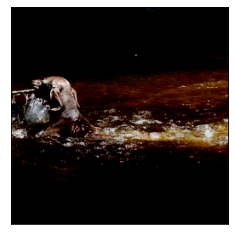

...............................................
<sos> a dog is running through the grass <eos>


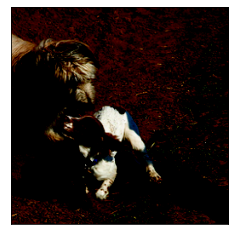

...............................................
<sos> a man in a red shirt is standing on a bench with a <unk> in the background <eos>


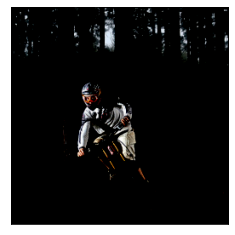

...............................................
Epoch 14 has started......
Training the network......
Iteration:20 	 Loss:2.91633
Iteration:40 	 Loss:2.92018
Iteration:60 	 Loss:2.92129
Iteration:80 	 Loss:2.92482
Iteration:100 	 Loss:2.92168
Iteration:120 	 Loss:2.92197
Iteration:140 	 Loss:2.91996
At the end of epoch 14 the average train loss is: 2.91825
Testing the network......
<sos> a man in a red shirt and a black hat and a black hat and a black hat and a black hat <eos>


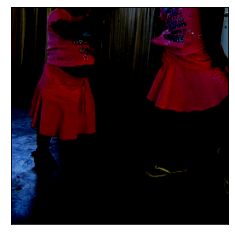

...............................................
<sos> a man in a red shirt and a black hat and a black hat and a woman in a blue shirt and a black hat <eos>


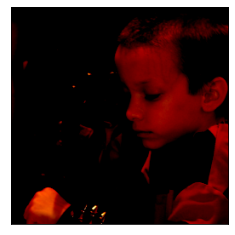

...............................................
<sos> a man in a red shirt is standing on a bench with a <unk> in the background <eos>


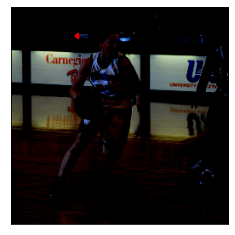

...............................................
Epoch 15 has started......
Training the network......
Iteration:20 	 Loss:2.90028
Iteration:40 	 Loss:2.89470
Iteration:60 	 Loss:2.88958
Iteration:80 	 Loss:2.88911
Iteration:100 	 Loss:2.88656
Iteration:120 	 Loss:2.88566
Iteration:140 	 Loss:2.88245
At the end of epoch 15 the average train loss is: 2.88147
Testing the network......
<sos> a man in a red shirt is standing on a bench with a <unk> in the background <eos>


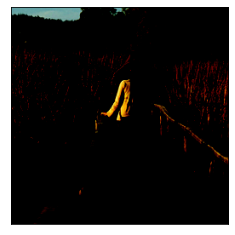

...............................................
<sos> a man in a red shirt and a black hat and a black hat and a black hat <eos>


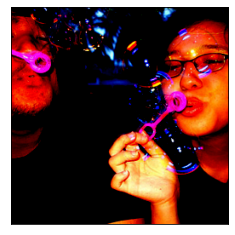

...............................................
<sos> a dog is running through the grass <eos>


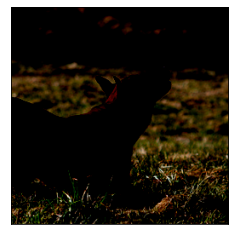

...............................................
Epoch 16 has started......
Training the network......
Iteration:20 	 Loss:2.85739
Iteration:40 	 Loss:2.85142
Iteration:60 	 Loss:2.84680
Iteration:80 	 Loss:2.84701
Iteration:100 	 Loss:2.84688
Iteration:120 	 Loss:2.85047
Iteration:140 	 Loss:2.84884
At the end of epoch 16 the average train loss is: 2.84884
Testing the network......
<sos> a man in a red shirt is riding a bike on a dirt bike <eos>


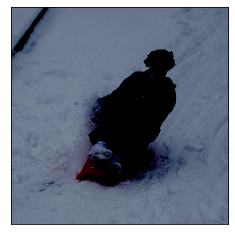

...............................................
<sos> a man in a red shirt is riding a bike on a dirt bike <eos>


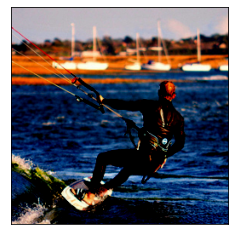

...............................................
<sos> a man in a red shirt is standing on a bench with a <unk> in the background <eos>


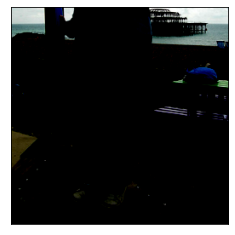

...............................................
Epoch 17 has started......
Training the network......
Iteration:20 	 Loss:2.81702
Iteration:40 	 Loss:2.81086
Iteration:60 	 Loss:2.81439
Iteration:80 	 Loss:2.81553
Iteration:100 	 Loss:2.81812
Iteration:120 	 Loss:2.81728
Iteration:140 	 Loss:2.81747
At the end of epoch 17 the average train loss is: 2.81845
Testing the network......
<sos> a man in a red shirt is riding a bike on a dirt bike <eos>


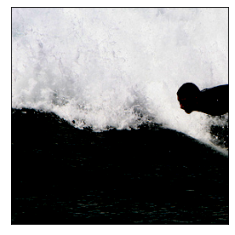

...............................................
<sos> a man in a red shirt and a black hat and a black hat and a black hat is standing on a bench <eos>


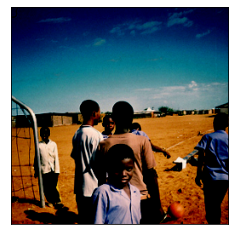

...............................................
<sos> a man in a red shirt is riding a bike on a dirt bike <eos>


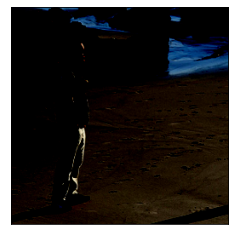

...............................................
Epoch 18 has started......
Training the network......
Iteration:20 	 Loss:2.80530
Iteration:40 	 Loss:2.79523
Iteration:60 	 Loss:2.78926
Iteration:80 	 Loss:2.79251
Iteration:100 	 Loss:2.79001
Iteration:120 	 Loss:2.79018
Iteration:140 	 Loss:2.78872
At the end of epoch 18 the average train loss is: 2.78695
Testing the network......
<sos> a dog is running through the grass <eos>


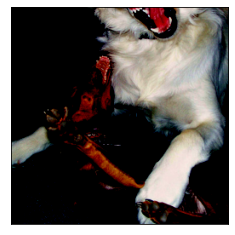

...............................................
<sos> a dog is running through the grass <eos>


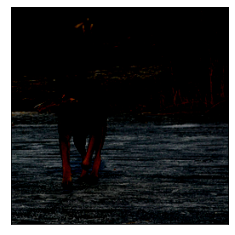

...............................................
<sos> a man in a red shirt and a black shirt and a black dog <eos>


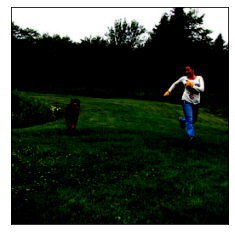

...............................................
Epoch 19 has started......
Training the network......
Iteration:20 	 Loss:2.76096
Iteration:40 	 Loss:2.75913
Iteration:60 	 Loss:2.76285
Iteration:80 	 Loss:2.75917
Iteration:100 	 Loss:2.75966
Iteration:120 	 Loss:2.76037
Iteration:140 	 Loss:2.75884
At the end of epoch 19 the average train loss is: 2.76144
Testing the network......
<sos> a man in a blue shirt and a black shirt and a black dog <eos>


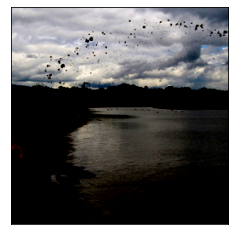

...............................................
<sos> a group of people are standing on a bench <eos>


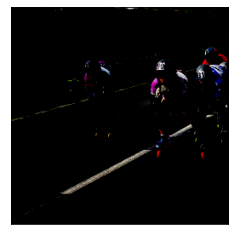

...............................................
<sos> a man in a red shirt and a black hat and a woman in a black shirt and a black hat <eos>


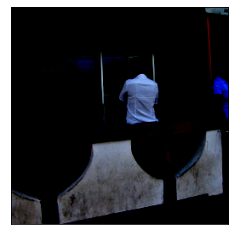

...............................................
Epoch 20 has started......
Training the network......
Iteration:20 	 Loss:2.74723
Iteration:40 	 Loss:2.74001
Iteration:60 	 Loss:2.74171
Iteration:80 	 Loss:2.73526
Iteration:100 	 Loss:2.73416
Iteration:120 	 Loss:2.73173
Iteration:140 	 Loss:2.73457
At the end of epoch 20 the average train loss is: 2.73505


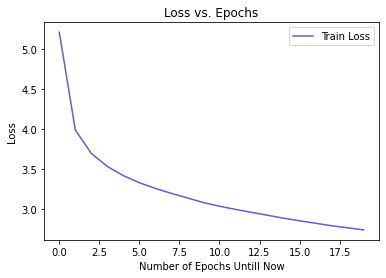

Testing the network......
<sos> a man in a red shirt and a black hat and a backpack <eos>


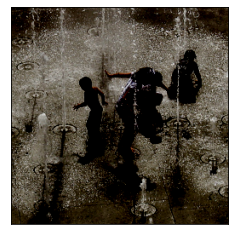

...............................................
<sos> a man in a blue shirt is riding a bike on a dirt path <eos>


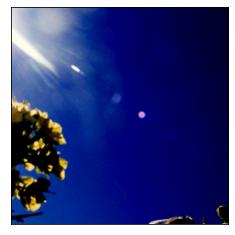

...............................................
<sos> a man in a red shirt and a black hat and a woman in a black shirt and a black hat <eos>


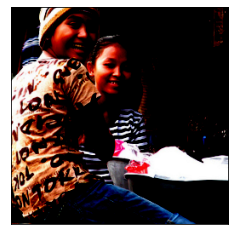

...............................................
Epoch 21 has started......
Training the network......
Iteration:20 	 Loss:2.72335
Iteration:40 	 Loss:2.70791
Iteration:60 	 Loss:2.71095
Iteration:80 	 Loss:2.71081
Iteration:100 	 Loss:2.70608
Iteration:120 	 Loss:2.70831
Iteration:140 	 Loss:2.70954
At the end of epoch 21 the average train loss is: 2.71112
Testing the network......
<sos> a young boy in a blue shirt is jumping into a pool <eos>


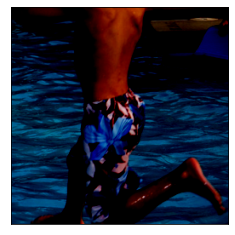

...............................................
<sos> a man in a black shirt and a black hat is standing in front of a crowd of people <eos>


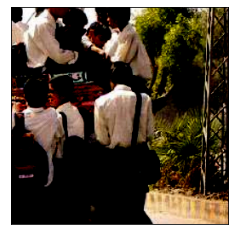

...............................................
<sos> a man in a red shirt is riding a bike on a dirt bike <eos>


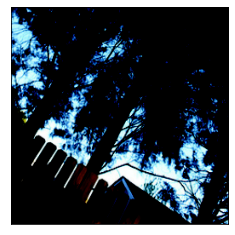

...............................................
Epoch 22 has started......
Training the network......
Iteration:20 	 Loss:2.70859
Iteration:40 	 Loss:2.70427
Iteration:60 	 Loss:2.69510
Iteration:80 	 Loss:2.69396
Iteration:100 	 Loss:2.69400
Iteration:120 	 Loss:2.69089
Iteration:140 	 Loss:2.68790
At the end of epoch 22 the average train loss is: 2.68734
Testing the network......
<sos> a man in a red shirt is standing on a bench with a <unk> in his hand <eos>


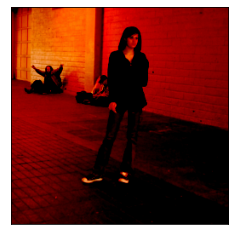

...............................................
<sos> a man in a red shirt is playing with a tennis ball in his mouth <eos>


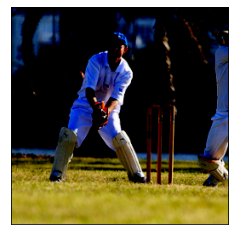

...............................................
<sos> a man in a red shirt and a woman in a black shirt and a black hat <eos>


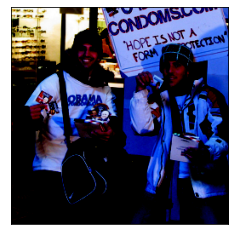

...............................................
Epoch 23 has started......
Training the network......
Iteration:20 	 Loss:2.66001
Iteration:40 	 Loss:2.67028
Iteration:60 	 Loss:2.66468
Iteration:80 	 Loss:2.66374
Iteration:100 	 Loss:2.66594
Iteration:120 	 Loss:2.66846
Iteration:140 	 Loss:2.66677
At the end of epoch 23 the average train loss is: 2.66781
Testing the network......
<sos> a black dog is running through the grass <eos>


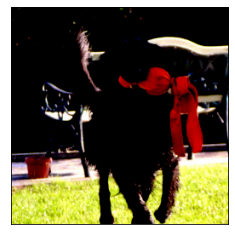

...............................................
<sos> a man in a red shirt is climbing a rock face <eos>


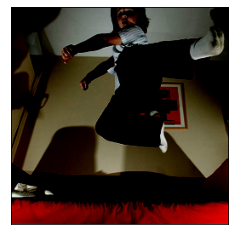

...............................................
<sos> a dog is running through the grass <eos>


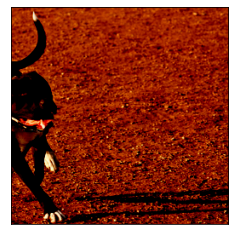

...............................................
Epoch 24 has started......
Training the network......
Iteration:20 	 Loss:2.63885
Iteration:40 	 Loss:2.63990
Iteration:60 	 Loss:2.64027
Iteration:80 	 Loss:2.64370
Iteration:100 	 Loss:2.64716
Iteration:120 	 Loss:2.64797
Iteration:140 	 Loss:2.64825
At the end of epoch 24 the average train loss is: 2.64634
Testing the network......
<sos> a man in a red shirt is riding a bike on a dirt track <eos>


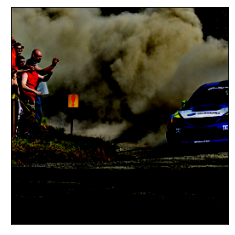

...............................................
<sos> a man in a red shirt is riding a bike on a dirt bike <eos>


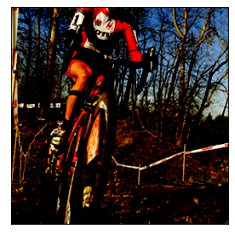

...............................................
<sos> a boy in a red shirt is playing with a soccer ball <eos>


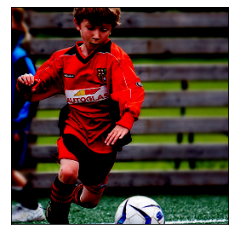

...............................................
Epoch 25 has started......
Training the network......
Iteration:20 	 Loss:2.61842
Iteration:40 	 Loss:2.62655
Iteration:60 	 Loss:2.63060
Iteration:80 	 Loss:2.62624
Iteration:100 	 Loss:2.62661
Iteration:120 	 Loss:2.62732
Iteration:140 	 Loss:2.62583
At the end of epoch 25 the average train loss is: 2.62699
Testing the network......
<sos> a group of people are standing in front of a building <eos>


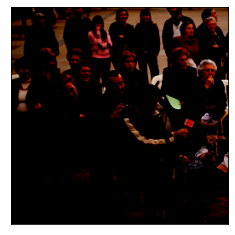

...............................................
<sos> a brown dog is running through the grass <eos>


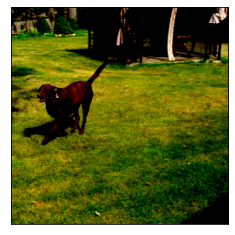

...............................................
<sos> a dog is running through the water <eos>


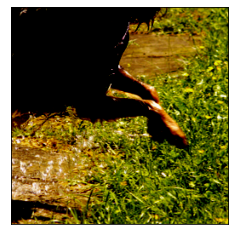

...............................................
Epoch 26 has started......
Training the network......
Iteration:20 	 Loss:2.61052
Iteration:40 	 Loss:2.60688
Iteration:60 	 Loss:2.60500
Iteration:80 	 Loss:2.60815
Iteration:100 	 Loss:2.60965
Iteration:120 	 Loss:2.61166
Iteration:140 	 Loss:2.60884
At the end of epoch 26 the average train loss is: 2.60858
Testing the network......
<sos> a man in a red shirt and a woman in a white shirt and a black hat <eos>


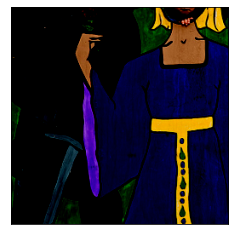

...............................................
<sos> a man in a red shirt is standing on a rock wall <eos>


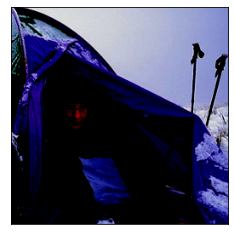

...............................................
<sos> a man in a red shirt is riding a bike on a dirt bike <eos>


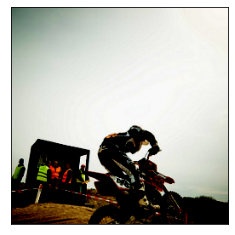

...............................................
Epoch 27 has started......
Training the network......
Iteration:20 	 Loss:2.59380
Iteration:40 	 Loss:2.59258
Iteration:60 	 Loss:2.59282
Iteration:80 	 Loss:2.59298
Iteration:100 	 Loss:2.59465
Iteration:120 	 Loss:2.59378
Iteration:140 	 Loss:2.59296
At the end of epoch 27 the average train loss is: 2.59239
Testing the network......
<sos> a man in a red shirt and a woman in a black shirt and a black hat <eos>


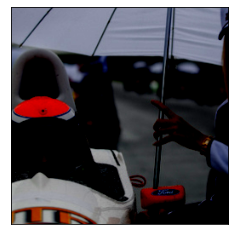

...............................................
<sos> a young boy in a blue shirt is jumping into a pool <eos>


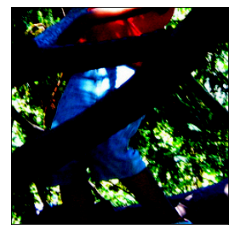

...............................................
<sos> a group of people are walking on a beach <eos>


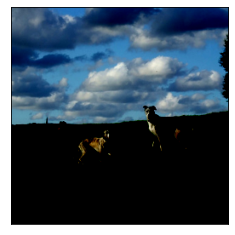

...............................................
Epoch 28 has started......
Training the network......
Iteration:20 	 Loss:2.56978
Iteration:40 	 Loss:2.58286
Iteration:60 	 Loss:2.58358
Iteration:80 	 Loss:2.57736
Iteration:100 	 Loss:2.57501
Iteration:120 	 Loss:2.57377
Iteration:140 	 Loss:2.57520
At the end of epoch 28 the average train loss is: 2.57826
Testing the network......
<sos> a man in a red shirt is climbing a rock wall <eos>


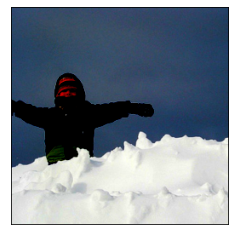

...............................................
<sos> a man in a red shirt and a woman in a black shirt and a woman in a black shirt <eos>


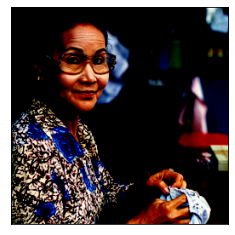

...............................................
<sos> a man in a red shirt and a black hat is standing in front of a building <eos>


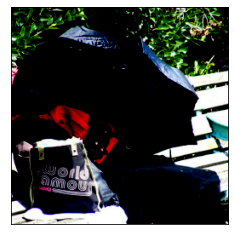

...............................................
Epoch 29 has started......
Training the network......
Iteration:20 	 Loss:2.56062
Iteration:40 	 Loss:2.55673
Iteration:60 	 Loss:2.55935
Iteration:80 	 Loss:2.55962
Iteration:100 	 Loss:2.56146
Iteration:120 	 Loss:2.56015
Iteration:140 	 Loss:2.56119
At the end of epoch 29 the average train loss is: 2.56145
Testing the network......
<sos> a man in a red shirt and a woman in a black shirt and a black hat <eos>


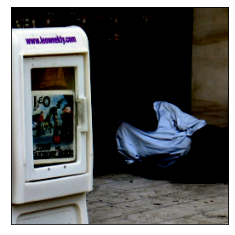

...............................................
<sos> a dog is running through the snow <eos>


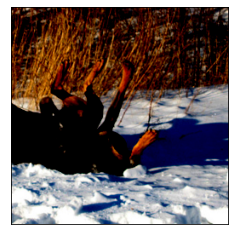

...............................................
<sos> a black dog is running through the grass <eos>


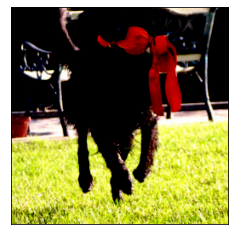

...............................................
Epoch 30 has started......
Training the network......
Iteration:20 	 Loss:2.54299
Iteration:40 	 Loss:2.54510
Iteration:60 	 Loss:2.54493
Iteration:80 	 Loss:2.54926
Iteration:100 	 Loss:2.54807
Iteration:120 	 Loss:2.54963
Iteration:140 	 Loss:2.54724
At the end of epoch 30 the average train loss is: 2.54660


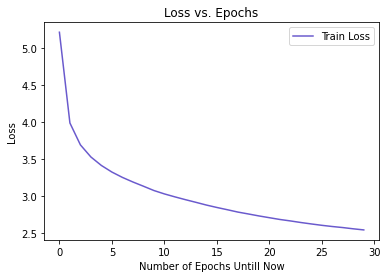

Testing the network......
<sos> a man in a red shirt is riding a bike on a skateboard <eos>


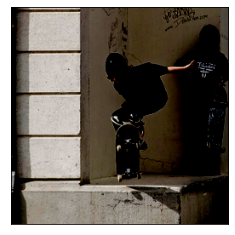

...............................................
<sos> a man in a black shirt and black shorts is standing in front of a large rock <eos>


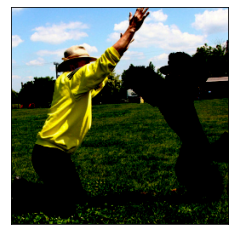

...............................................
<sos> a woman in a black dress is holding a baby in a <unk> <eos>


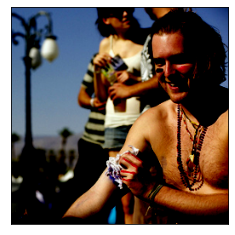

...............................................


In [ ]:
train(trainDataLoader, trainDataset, testDataLoader, testDataset, freezeState=False)